# Estudio de las Ventas de una Ferretería
## NB1: Carga y limpieza de los Datos

>Autor: Diana Chacón Ocariz

### Contenido

1. [Introducción](#introduccion)
1. [Fuentes de Datos](#fuentes-datos)
1. [Carga de Librerías](#carga-librerias)
1. [Carga y limpieza de datos del histórico de Ventas (2020)](#carga-historico)
    1. [Archivo hitórico NE](#historico-ne)
    1. [Archivo hitórico FA](#historico-fa) 
1. [Carga y limpieza de datos de Ventas a partir del 2021](#carga-ventas)
    1. [Construcción DF definitivo](#df-definitivo)
1. [Unión del Histórico con las Ventas desde 2021](#total-ventas)
1. [Tasa de Cambio](#tasa-cambio)
    1. [Cálculo Montos en Dólares](#monto_dolares)
1. [Carga y limpieza de datos del Inventario](#carga-inventario)
1. [Almacenamiento de los DF](#almacenamiento-df)

## 1. Introducción<a name="introduccion"></a>

Se trata de una pequeña ferretería que maneja un poco más de 3.000 productos distintos. Poseen un software de gestión genérico que les provee una gran cantidad de reportes, básicamente tablas con números, díficiles de analizar (un reporte puede constar de varias decenas de páginas).

En este **primer notebook del estudio**, cargaremos los datos, los limpiaremos, haremos las transformaciones necesarias y los almacenaremos en diversos formatos (parquet, csv y xlsx) para ser utilizados posteriormente en otros notebooks u otras herramientas.

    
## 2. Fuentes de Datos<a name="fuentes-datos"></a>

Se trata de datos reales provenientes del software de gestión de la empresa. 

Por razones de seguridad, para este estudio eliminamos toda la información concerniente a los clientes. Cualquier uso de los datos fuera de este estudio, deberá ser notificado a la empresa.

Los datos provienen de reportes del software de gestión, Se trata de archivos .xls que contienen sólo datos:

- Histórico de Ventas del 2020: fa_hist_2020.xls y ne_hist_2020.xls
- Ventas por producto del 01/01/2021 al 28/02/2022: fa_art_*.xls y ne_art_*.xls (varios archivos)
- Inventario al 28/02/2022: 2022-02-28-inv.xls

También utilizamos el histórico de la tasa de cambio del dólar para hacer el análisis en base a montos en esta moneda y paliar los problemas de inflación (ver detalle en [NB5: Scraper Tasa de Cambio Dólar](https://github.com/dchaconoca/proyecto-ventas/blob/master/NB5_scraper_tasa_dolar.ipynb))

Todos los archivos se encuentran en el subdirectorio **datos/in**

## 3. Carga de librerías<a name="carga-librerias"></a>

In [1]:
# Librerías utilizadas

import os
import glob
from pathlib import Path

import pandas as pd

In [2]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

In [3]:
# Lectura de los archivos y creación de un DF con todos los datos
    
def read_files(FILES, col, long):

    df = pd.DataFrame()

    for filename in glob.glob(f"{BASE_DIR / FILES}"):
        df_aux = pd.read_excel(filename)
        
        info_file = Path(filename).name[:long]
        df_aux[col] = info_file

        df = pd.concat([df, df_aux])

    return df

## 4. Carga y limpieza de datos del histórico de Ventas (2020) <a name="carga-historico"></a>


Tenemos 2 archivos: fa_hist_2020.xls y ne_hist_2020.xls 

Los 2 tienen formato diferente (n° de columnas), pero conservaremos de los 2 la información común, básicamente los datos de una venta.

### 4.A Archivo hitórico NE <a name="historico-ne"></a>

Los datos están agrupados por fecha y contienen un total: Eliminaremos las líneas de encabezado y de totales.Por eso existe un desplazamiento entre el encabezado de las columnas y la verdadera información que contienen.

**Metadatos:**

    - Número: Número de la factura (conservamos como num)       
    - Vendedor: Código del Vendedor (conservamos como vendedor)      
    - Nº Control: Código de control (no conservamos)    
    - Venc.: Fecha de emisión, fecha de la venta (conservamos como fecha_comp: fecha completa)      
    - Neto: Neto o total de la venta (conservamos como monto)

In [4]:
FILES_NE_HIST = 'datos/in/ne_hist*.xls'
FILES_NE_HIST

'datos/in/ne_hist*.xls'

In [5]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_NE_HIST}")]

['ne_hist_2020.xls']

In [6]:
%%time

df_ne_hist = read_files(FILES_NE_HIST, 'tipo', 2)

df_ne_hist

CPU times: user 174 ms, sys: 4.34 ms, total: 178 ms
Wall time: 197 ms


,Número,Vendedor,Nº Control,Venc.,Neto,tipo
0,07/01/2020,NaN,NaN,NaT,NaN,ne
1,0000000001,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
2,Total del Día:,NaN,NaN,NaT,NaN,ne
3,31/01/2020,NaN,NaN,NaT,NaN,ne
4,0000000003,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
...,...,...,...,...,...,...
4809,0000004510,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne
4811,0000004512,14.0,31122020,2020-12-31 12:04:00,5700000.0,ne
4812,Total del Día:,NaN,NaN,NaT,NaN,ne


In [7]:
df_ne_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4814 entries, 0 to 4813
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Número      4814 non-null   object        
 1   Vendedor    4485 non-null   float64       
 2   Nº Control  4485 non-null   object        
 3   Venc.       4485 non-null   datetime64[ns]
 4    Neto       4485 non-null   float64       
 5   tipo        4814 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 225.8+ KB


In [8]:
# Buscamos las filas con valores NaN 
# Corresponden a los encabezados de las ventas del día
# y los totales
df_ne_hist[ df_ne_hist.isnull().values ]

,Número,Vendedor,Nº Control,Venc.,Neto,tipo
0,07/01/2020,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaT,NaN,ne
0,07/01/2020,NaN,NaN,NaT,NaN,ne
2,Total del Día:,NaN,NaN,NaT,NaN,ne
...,...,...,...,...,...,...
4812,Total del Día:,NaN,NaN,NaT,NaN,ne
4813,Totales:,NaN,NaN,NaT,NaN,ne
4813,Totales:,NaN,NaN,NaT,NaN,ne
4813,Totales:,NaN,NaN,NaT,NaN,ne


In [9]:
# Eliminamos los registros que contienen NaN ya que corresponden a 
df_ne_hist.dropna(inplace=True)
df_ne_hist

,Número,Vendedor,Nº Control,Venc.,Neto,tipo
1,0000000001,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
4,0000000003,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
7,0000000004,1.0,05022020,2020-02-05 11:10:00,3365523.6,ne
10,0000000005,1.0,28022020,2020-02-28 14:57:00,150000000.0,ne
13,0000000006,1.0,06032020,2020-03-06 13:56:00,1045740.0,ne
...,...,...,...,...,...,...
4807,0000004508,7.0,A-311220,2020-12-31 11:11:00,12500000.0,ne
4808,0000004509,7.0,A-311220,2020-12-31 11:43:00,4112500.0,ne
4809,0000004510,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne


In [10]:
# Cambio del nombre de las columnas
df_ne_hist.columns

Index(['Número', 'Vendedor', 'Nº Control', 'Venc.', ' Neto', 'tipo'], dtype='object')

In [11]:
cols = ['num', 
        'vendedor',
        'control',
        'fecha_comp',
        'monto',
        'tipo']

In [12]:
df_ne_hist.columns = cols
df_ne_hist

,num,vendedor,control,fecha_comp,monto,tipo
1,0000000001,1.0,07012019,2020-01-07 11:04:00,170601.2,ne
4,0000000003,11.0,00-0013,2020-01-31 14:57:00,1661120.0,ne
7,0000000004,1.0,05022020,2020-02-05 11:10:00,3365523.6,ne
10,0000000005,1.0,28022020,2020-02-28 14:57:00,150000000.0,ne
13,0000000006,1.0,06032020,2020-03-06 13:56:00,1045740.0,ne
...,...,...,...,...,...,...
4807,0000004508,7.0,A-311220,2020-12-31 11:11:00,12500000.0,ne
4808,0000004509,7.0,A-311220,2020-12-31 11:43:00,4112500.0,ne
4809,0000004510,7.0,A-311220,2020-12-31 11:43:00,1500000.0,ne
4810,0000004511,7.0,A-311220,2020-12-31 11:46:00,8450000.0,ne


In [13]:
df_ne_hist = df_ne_hist.loc[:,['num', 'fecha_comp', 'vendedor', 'monto', 'tipo']]
df_ne_hist

,num,fecha_comp,vendedor,monto,tipo
1,0000000001,2020-01-07 11:04:00,1.0,170601.2,ne
4,0000000003,2020-01-31 14:57:00,11.0,1661120.0,ne
7,0000000004,2020-02-05 11:10:00,1.0,3365523.6,ne
10,0000000005,2020-02-28 14:57:00,1.0,150000000.0,ne
13,0000000006,2020-03-06 13:56:00,1.0,1045740.0,ne
...,...,...,...,...,...
4807,0000004508,2020-12-31 11:11:00,7.0,12500000.0,ne
4808,0000004509,2020-12-31 11:43:00,7.0,4112500.0,ne
4809,0000004510,2020-12-31 11:43:00,7.0,1500000.0,ne
4810,0000004511,2020-12-31 11:46:00,7.0,8450000.0,ne


In [14]:
df_ne_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4485 entries, 1 to 4811
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         4485 non-null   object        
 1   fecha_comp  4485 non-null   datetime64[ns]
 2   vendedor    4485 non-null   float64       
 3   monto       4485 non-null   float64       
 4   tipo        4485 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 210.2+ KB


### 4.B Archivo hitórico FA <a name="historico-fa"></a>

Existe un desplazamiento entre el encabezado de las columnas y la verdadera información que poseen.

**Metadatos:**

    - Número: Número de la factura (conservamos como num)  
    - Emisión: Fecha de emisión, fecha de la venta (conservamos como fecha_comp: fecha completa)
    - Venc.: Fecha de vencimiento (no conservamos)
    - Vendedor: Código del Vendedor (conservamos como vendedor)    
    - Monto Base: Monto base (no conservamos) 
    - I.V.A.:  IVA (no conservamos)
    - Otros: Otras cargas (no conservamos)
    - Neto: Neto o total de la venta (conservamos como monto)
    - Saldo: Saldo (no conservamos)

Eliminamos las líneas correspondientes a los totales del reporte.

In [15]:
FILES_FA_HIST = 'datos/in/fa_hist*.xls'
FILES_FA_HIST

'datos/in/fa_hist*.xls'

In [16]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_FA_HIST}")]

['fa_hist_2020.xls']

In [17]:
%%time

df_fa_hist = read_files(FILES_FA_HIST, 'tipo', 2)

df_fa_hist

CPU times: user 359 ms, sys: 367 µs, total: 359 ms
Wall time: 374 ms


,Número,Emisión,Venc.,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,tipo
0,0000000001,2020-01-06 14:06:00,2020-01-06 14:06:00,3.000000e+00,2077140,0.000000e+00,0,2.077140e+06,0.0,fa
1,0000000002,2020-01-06 14:38:00,2020-01-06 14:38:00,7.000000e+00,174720,0.000000e+00,0,1.747200e+05,0.0,fa
2,0000000003,2020-01-06 14:47:00,2020-01-06 14:47:00,7.000000e+00,101051.03,1.212612e+04,0,1.131771e+05,0.0,fa
3,0000000004,2020-01-06 14:35:00,2020-01-06 14:35:00,1.100000e+01,1465.66,1.758800e+02,0,1.641540e+03,0.0,fa
4,0000000005,2020-01-06 13:58:00,2020-01-06 13:58:00,1.100000e+01,34751.03,5.172000e+01,0,3.480275e+04,0.0,fa
...,...,...,...,...,...,...,...,...,...,...
6505,0000006531,2020-12-30 09:12:00,2020-12-30 09:12:00,7.000000e+00,2500000,4.000000e+05,0,2.900000e+06,0.0,fa
6506,0000006532,2020-12-30 10:48:00,2020-12-30 10:48:00,1.000000e+00,1112500,1.780000e+05,0,1.290500e+06,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,2021-01-09 14:59:00,7.000000e+00,9275000,1.484000e+06,0,1.075900e+07,0.0,fa
6508,0000006534,2020-12-31 10:03:00,2020-12-31 10:03:00,1.400000e+01,450000,7.200000e+04,0,5.220000e+05,0.0,fa


In [18]:
df_fa_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6510 entries, 0 to 6509
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Número      6510 non-null   object 
 1   Emisión     6510 non-null   object 
 2   Venc.       6510 non-null   object 
 3   Vendedor    6510 non-null   float64
 4   Monto Base  6510 non-null   object 
 5   I.V.A.      6510 non-null   float64
 6   Otros       6510 non-null   object 
 7   Neto        6510 non-null   float64
 8   Saldo       6509 non-null   float64
 9   tipo        6510 non-null   object 
dtypes: float64(4), object(6)
memory usage: 508.7+ KB


In [19]:
# Buscamos las filas con valores NaN 
# Corresponden a los totales del reporte
df_fa_hist[ df_fa_hist.isnull().values ]

,Número,Emisión,Venc.,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,tipo
6509,Totales:,20276869997.040001,1465210270.24,1.532014e+09,Total de ventas a contado:,2.021077e+10,Total de ventas a credito:,1.532014e+09,NaN,fa


In [20]:
# Eliminamos los registros que contienen NaN ya que corresponden a 
# líneas de totales de los reportes 
df_fa_hist.dropna(inplace=True)
df_fa_hist

,Número,Emisión,Venc.,Vendedor,Monto Base,I.V.A.,Otros,Neto,Saldo,tipo
0,0000000001,2020-01-06 14:06:00,2020-01-06 14:06:00,3.0,2077140,0.00,0,2.077140e+06,0.0,fa
1,0000000002,2020-01-06 14:38:00,2020-01-06 14:38:00,7.0,174720,0.00,0,1.747200e+05,0.0,fa
2,0000000003,2020-01-06 14:47:00,2020-01-06 14:47:00,7.0,101051.03,12126.12,0,1.131771e+05,0.0,fa
3,0000000004,2020-01-06 14:35:00,2020-01-06 14:35:00,11.0,1465.66,175.88,0,1.641540e+03,0.0,fa
4,0000000005,2020-01-06 13:58:00,2020-01-06 13:58:00,11.0,34751.03,51.72,0,3.480275e+04,0.0,fa
...,...,...,...,...,...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,2020-12-29 17:15:00,7.0,112425000,13028000.00,0,1.254530e+08,0.0,fa
6505,0000006531,2020-12-30 09:12:00,2020-12-30 09:12:00,7.0,2500000,400000.00,0,2.900000e+06,0.0,fa
6506,0000006532,2020-12-30 10:48:00,2020-12-30 10:48:00,1.0,1112500,178000.00,0,1.290500e+06,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,2021-01-09 14:59:00,7.0,9275000,1484000.00,0,1.075900e+07,0.0,fa


In [21]:
df_fa_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6509 entries, 0 to 6508
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Número      6509 non-null   object 
 1   Emisión     6509 non-null   object 
 2   Venc.       6509 non-null   object 
 3   Vendedor    6509 non-null   float64
 4   Monto Base  6509 non-null   object 
 5   I.V.A.      6509 non-null   float64
 6   Otros       6509 non-null   object 
 7   Neto        6509 non-null   float64
 8   Saldo       6509 non-null   float64
 9   tipo        6509 non-null   object 
dtypes: float64(4), object(6)
memory usage: 559.4+ KB


In [22]:
cols = ['num', 
        'fecha_comp',
        'venc',
        'vendedor',
        'base',
        'iva',
        'otros',
        'monto',
        'saldo',
        'tipo']

In [23]:
df_fa_hist.columns = cols
df_fa_hist = df_fa_hist.loc[:,['num', 'fecha_comp', 'vendedor', 'monto', 'tipo']]
df_fa_hist

,num,fecha_comp,vendedor,monto,tipo
0,0000000001,2020-01-06 14:06:00,3.0,2.077140e+06,fa
1,0000000002,2020-01-06 14:38:00,7.0,1.747200e+05,fa
2,0000000003,2020-01-06 14:47:00,7.0,1.131771e+05,fa
3,0000000004,2020-01-06 14:35:00,11.0,1.641540e+03,fa
4,0000000005,2020-01-06 13:58:00,11.0,3.480275e+04,fa
...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,7.0,1.254530e+08,fa
6505,0000006531,2020-12-30 09:12:00,7.0,2.900000e+06,fa
6506,0000006532,2020-12-30 10:48:00,1.0,1.290500e+06,fa
6507,0000006533,2020-12-30 14:59:00,7.0,1.075900e+07,fa


In [24]:
# Unimos los 2 DF para obtener el histórico completo del 2020
df_hist = pd.concat([df_ne_hist, df_fa_hist])
df_hist

,num,fecha_comp,vendedor,monto,tipo
1,0000000001,2020-01-07 11:04:00,1.0,170601.2,ne
4,0000000003,2020-01-31 14:57:00,11.0,1661120.0,ne
7,0000000004,2020-02-05 11:10:00,1.0,3365523.6,ne
10,0000000005,2020-02-28 14:57:00,1.0,150000000.0,ne
13,0000000006,2020-03-06 13:56:00,1.0,1045740.0,ne
...,...,...,...,...,...
6504,0000006530,2020-12-29 17:15:00,7.0,125453000.0,fa
6505,0000006531,2020-12-30 09:12:00,7.0,2900000.0,fa
6506,0000006532,2020-12-30 10:48:00,1.0,1290500.0,fa
6507,0000006533,2020-12-30 14:59:00,7.0,10759000.0,fa


## 5. Carga y limpieza de Datos de las Ventas a partir de 2021 <a name="carga-ventas"></a>

Aunque los datos no tienen ningún formato especial de Excel, tienen la forma de un reporte con totales, subtotales y datos agrupados por producto. Procedemos a hacer las transformaciones siguientes:

- **Eliminación de totales:** Eliminamos las lineas que continen "total" ya que son los totales y subtotales de los reportes
- **Eliminación de información no relevante:** Conservaremos solo las siguientes columnas: Número, Emisión, Cliente, Vendedor, Cantidad, Neto y Tipo 
- **Construcción del DF definitvo:** Recorreremos el DF para recuperar la información por producto y crearemos un nuevo DF con los datos definitivos
- **Cambio tipos columnas:** Cambiamos el tipo a la columna Vendedor para que sea de tipo entero. Transformamos el campo de fecha para que sea de tipo datetime. Transformamos la columna num a str

In [25]:
FILES_VENTAS = 'datos/in/*art*.xls'
FILES_VENTAS

'datos/in/*art*.xls'

In [26]:
[Path(filename).name for filename in glob.glob(f"{BASE_DIR / FILES_VENTAS}")]

['ne_art_2022_01_31.xls',
 'fa_art_2022_02_28.xls',
 'ne_art_2022_02_15.xls',
 'ne_art_2022_02_28.xls',
 'fa_art_2022_01_31.xls',
 'fa_art_2021.xls',
 'ne_art_2021.xls',
 'fa_art_2022_02_15.xls']

In [27]:
%%time

df = read_files(FILES_VENTAS, 'tipo', 2)

df.sample(15)

CPU times: user 2.48 s, sys: 27.8 ms, total: 2.51 s
Wall time: 2.58 s


,Número,Reng,Emisión,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
10871,0000000972,1,2021-07-22 11:50:00,14.0,1.00,6.0,UNI,0.16000,0.96,0.00,0.0,0.96,ne
5810,0000003621,4,2021-10-15 16:00:00,13.0,1.00,2.0,UNI,6.66666,13.33,0.00,0.0,13.33,ne
14002,0000006039,2,2021-10-01 14:16:00,10.0,1.00,5.0,UNI,103.70000,103.70,16.59,0.0,120.29,fa
9523,0000004188,3,2021-11-05 10:40:00,7.0,1.00,2.0,UNI,1.82000,3.64,0.00,0.0,3.64,ne
11423,0000003010,1,2021-09-27 10:37:00,13.0,1.00,10.0,UNI,5.56000,55.60,0.00,0.0,55.60,ne
1116,0000004983,3,2021-11-30 14:03:00,13.0,1.00,11.0,UNI,5.00000,55.00,0.00,0.0,55.00,ne
711,Sub-Totales:,11,21.39,0.0,21.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
543,00243,NaN,"NIPLE HG 3/4"" * 10CTM/4""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
14231,0000003179,1,2021-10-01 15:11:00,10.0,1.00,1.0,UNI,4.20000,4.20,0.00,0.0,4.20,ne
2651,0000007568,3,2022-02-04 16:17:00,7.0,1.00,2.0,UNI,3.95000,7.90,0.00,0.0,7.90,ne


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45135 entries, 0 to 655
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Número            45135 non-null  object 
 1   Reng              39529 non-null  object 
 2   Emisión           45135 non-null  object 
 3   Vendedor          38818 non-null  float64
 4   Almacén           38818 non-null  float64
 5   Cantidad          32493 non-null  float64
 6   Unid.             32493 non-null  object 
 7   Precio Unitario   32493 non-null  float64
 8   Monto Base        32493 non-null  float64
 9   I.V.A.            32493 non-null  float64
 10  Otros             32493 non-null  float64
 11  Neto              32493 non-null  float64
 12  tipo              45135 non-null  object 
dtypes: float64(8), object(5)
memory usage: 4.8+ MB


In [29]:
# Buscamos las filas de totales y subtotales para eliminarlas
df[df.Número.str.contains('Totales')] 

,Número,Reng,Emisión,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
5,Sub-Totales:,4,35.1,0.0,35.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
25,Sub-Totales:,86,498.96,0.0,498.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
46,Sub-Totales:,42,744.61,0.0,744.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
51,Sub-Totales:,4,112.2,0.0,112.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
57,Sub-Totales:,33,188.82,0.0,188.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,Sub-Totales:,1,204.6,0.0,237.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
648,Sub-Totales:,1,139.5,0.0,139.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
651,Sub-Totales:,1,23.81,0.0,23.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
654,Sub-Totales:,6,5.58,0.0,6.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa


In [30]:
df_aux = df[~df.Número.str.contains('Totales')]
df_aux

,Número,Reng,Emisión,Vendedor,Almacén,Cantidad,Unid.,Precio Unitario,Monto Base,I.V.A.,Otros,Neto,tipo
0,00001,NaN,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ne
1,0000006016,1,2022-01-03 08:38:00,14.0,1.0,1.0,UNI,8.6400,8.64,0.00,0.0,8.64,ne
2,0000006482,1,2022-01-12 16:15:00,13.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
3,0000006530,2,2022-01-13 15:29:00,7.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
4,0000006625,1,2022-01-17 08:50:00,7.0,1.0,1.0,UNI,8.8200,8.82,0.00,0.0,8.82,ne
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0000006523,1,2022-02-10 16:01:00,10.0,1.0,1.0,UNI,139.5000,139.50,0.00,0.0,139.50,fa
649,06359,NaN,CUCHILLA 1 PASE 2P 60A KS KNIFE SWITCH CAJA RO...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa
650,0000006536,1,2022-02-12 11:03:00,1.0,1.0,1.0,UNI,23.8094,23.81,0.00,0.0,23.81,fa
652,06362,NaN,"TORNILLO 1/4""*2"" HEX. NC G2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fa


In [31]:
# Cambiamos el nombre de las columnas
df_aux.columns

Index(['Número', 'Reng', 'Emisión ', 'Vendedor', 'Almacén', 'Cantidad',
       'Unid.', 'Precio Unitario ', 'Monto Base', 'I.V.A.', 'Otros', 'Neto',
       'tipo'],
      dtype='object')

In [32]:
cols = ['num', 'reng', 'fecha_comp', 'vendedor', 'almacen', 'cantidad',
       'und', 'precio', 'base', 'iva', 'otros', 'neto', 'tipo']
df_aux.columns = cols
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38810 entries, 0 to 653
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num         38810 non-null  object 
 1   reng        33204 non-null  object 
 2   fecha_comp  38810 non-null  object 
 3   vendedor    32493 non-null  float64
 4   almacen     32493 non-null  float64
 5   cantidad    32493 non-null  float64
 6   und         32493 non-null  object 
 7   precio      32493 non-null  float64
 8   base        32493 non-null  float64
 9   iva         32493 non-null  float64
 10  otros       32493 non-null  float64
 11  neto        32493 non-null  float64
 12  tipo        38810 non-null  object 
dtypes: float64(8), object(5)
memory usage: 4.1+ MB


In [33]:
df_aux = df_aux.loc[:,['num', 'fecha_comp', 'vendedor', 'cantidad', 'neto', 'tipo']]
df_aux.sample(15)


,num,fecha_comp,vendedor,cantidad,neto,tipo
16395,0000002901,2021-09-23 11:06:00,13.0,1.0,111.11,ne
3533,0000001296,2021-02-04 09:18:00,14.0,6.0,3.78,fa
134,0000006968,2022-01-24 11:49:00,7.0,20.0,195.20,ne
2816,0000005398,2021-06-21 11:13:00,10.0,1.0,3.71,fa
12667,0000005376,2021-12-10 10:37:00,13.0,1.0,213.26,ne
14379,0000001249,2021-07-30 15:01:00,11.0,1.0,10.50,ne
815,0000002137,2021-08-27 14:42:00,11.0,1.0,4.20,ne
7226,01142,"DESAGUE 1 1/4"" LAVAMANOS PUSH BOTTON O GIRATOR...",NaN,NaN,NaN,fa
3854,00512,ACCESORIOS PARA LAMPARAS,NaN,NaN,NaN,fa
3382,0000001304,2021-02-04 10:55:00,14.0,5.0,3.89,fa


### 5.A Construcción del DF definitivo<a name="df-definitivo"></a>

Los datos en el DF están agrupados por producto: Una línea tiene la información sobre el producto y las siguientes son las facturas que incluyen el producto. 

El objetivo es obtener un DF con la siguiente información por cada línea:

    - num: Número de factura (columna num)
    - fecha_comp: Fecha completa de la factura, incluida la hora de la factura (columna fecha_comp)
    - vendedor: Código del vendedor (columna vendedor)
    - cod: Código del producto (columna num cuando el largo <=5 )
    - producto: Descripción del producto (columna fecha)
    - cantidad: Cantidad de producto en la factura (columna cantidad)
    - monto: Monto neto del producto en la factura (columna neto)
    - tipo: Tipo de factura (columna tipo)
    
Para eso, recorremos el DF y lo vamos construyendo.

In [34]:
%%time

result = []

cod = ''
prod = ''

for index, row in df_aux.iterrows(): 
    if len(row['num']) <= 5 :
        cod = row['num']
        prod = row['fecha_comp']
    else:
        dic = {}
        dic['num'] = row['num']
        dic['fecha_comp'] = row['fecha_comp']
        dic['vendedor'] = row['vendedor']
        dic['cod'] = cod
        dic['producto'] = prod
        dic['cantidad'] = row['cantidad']
        dic['monto'] = row['neto']   
        dic['tipo'] = row['tipo'] 
        
        result.append(dic)


CPU times: user 3.91 s, sys: 36.4 ms, total: 3.94 s
Wall time: 4.03 s


In [35]:
df_ventas = pd.DataFrame(result)
df_ventas.sample(30)

,num,fecha_comp,vendedor,cod,producto,cantidad,monto,tipo
9611,0000000474,2021-01-15 16:16:00,7.0,00735,"BICICLETA RIN 26"" VICTORY COLOR AZUL",1.0,1.29,fa
13519,0000002344,2021-03-05 10:43:00,7.0,01840,R. VASTAGO FP,1.0,10.20,fa
11149,0000003214,2021-03-31 11:28:00,7.0,01017,"PVC SIFON 50MM/2"" COMPLETO ""TIPO A"" AGUAS NEGR...",4.0,17.16,fa
24400,0000003770,2021-10-21 11:43:00,3.0,00858,HOJA PARA SEGUETA LENOX 18 DIENTES METAL GRUESO,1.0,6.52,ne
23665,0000002712,2021-09-17 10:45:00,7.0,00776,BOLSA PLASTICA PEQUEÑA 10KRGS (USO INTERNO) UN...,1.0,0.04,ne
26435,0000003759,2021-10-21 10:38:00,14.0,01691,"TORNILLO 8*1-1/2"" AUTOROSCANTE ESTRIA",2.0,0.52,ne
24786,0000000124,2021-06-17 08:24:00,13.0,01006,"PVC ANILLO REDUCIDO 110MM/4""X50MM/2"" AGUAS NEG...",1.0,3.20,ne
17917,0000005807,2021-07-31 09:20:00,10.0,04616,"CANILLA 1/2""*1/2"" PLASTICA 40CMS LAVAMANOS",1.0,8.48,fa
21133,0000001210,2021-07-30 08:33:00,14.0,00260,"NIPLE PLASTICO 1"" * 80 CTM AZUL/GRIS CLASE A",1.0,12.18,ne
28073,0000000042,2021-06-07 09:53:00,3.0,03248,HERRAJE Nº 2 PARA BAÑO JOMAI,1.0,28.80,ne


In [36]:
df_ventas.describe()

,vendedor,cantidad,monto
count,32493.000000,32493.000000,32493.000000
mean,9.354015,4.488652,28.405360
std,3.495740,20.914017,114.604463
min,1.000000,0.020000,0.010000
25%,7.000000,1.000000,2.850000
50%,10.000000,1.000000,8.170000
75%,11.000000,3.000000,22.280000
max,14.000000,2000.000000,6133.500000


In [37]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32493 entries, 0 to 32492
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         32493 non-null  object        
 1   fecha_comp  32493 non-null  datetime64[ns]
 2   vendedor    32493 non-null  float64       
 3   cod         32493 non-null  object        
 4   producto    32493 non-null  object        
 5   cantidad    32493 non-null  float64       
 6   monto       32493 non-null  float64       
 7   tipo        32493 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 2.0+ MB


## 6. Unión del Histórico con las Ventas desde 2021<a name="total-ventas"></a>

Unimos el DF del histórico con el DF de las ventas a partir del 2021.

Solo los registros a partir del 2021 tienen información sobre el detalle de las facturas (producto y cantidad). Por lo tanto, será necesario hacer ciertas transformaciones a los datos del histórico.

In [38]:
df_ventas_totales = pd.concat([df_hist, df_ventas])
df_ventas_totales.sample(20)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad
15568,0000002525,2021-03-11 08:12:00,14.0,5.36,fa,03534,"TORNILLO DRYWALL Nº8*1-1/2""",67.0
12386,0000001417,2021-02-08 09:06:00,13.0,0.10,fa,01281,CONFITERIA CHICLE BON BON BUM,1.0
16790,0000005610,2021-06-28 11:06:00,14.0,27.91,fa,04183,"SOLDADURA 1/8"" HIERRO COLADO WEST ARCO (POR VA...",3.0
23294,0000003060,2021-09-28 11:47:00,13.0,2.15,ne,00775,"RIEGO ADAPTADOR MACHO 25MM * 1/2""",1.0
15562,0000001011,2021-01-28 10:53:00,11.0,7.60,fa,03529,"46FP 15/16""*3/8"" CONECTOR FLARE *HEMBRA NPT BR...",4.0
27795,0000005328,2021-12-09 10:15:00,13.0,7.00,ne,02794,"ARANDELA PLANA 3/8"" NACIONAL TANQUE AUSTRALIANO",20.0
1400,0000001403,2020-02-10 15:29:00,3.0,224193.20,fa,NaN,NaN,NaN
3130,0000003136,2020-04-15 09:50:00,14.0,130314.40,fa,NaN,NaN,NaN
3582,0000003335,2020-11-25 09:37:00,14.0,61860000.00,ne,NaN,NaN,NaN
5640,0000005650,2020-07-10 10:43:00,7.0,3181590.00,fa,NaN,NaN,NaN


In [39]:
# Reemplazamos los valores NaN por 0 en la columna cantidad para los registros del hitórico
# Reemplazamos los valores NaN por "" en las columnas cod y producto del histórico

df_ventas_totales.cantidad.fillna(0, inplace=True)
df_ventas_totales.fillna('', inplace=True)
df_ventas_totales

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad
1,0000000001,2020-01-07 11:04:00,1.0,1.706012e+05,ne,,,0.0
4,0000000003,2020-01-31 14:57:00,11.0,1.661120e+06,ne,,,0.0
7,0000000004,2020-02-05 11:10:00,1.0,3.365524e+06,ne,,,0.0
10,0000000005,2020-02-28 14:57:00,1.0,1.500000e+08,ne,,,0.0
13,0000000006,2020-03-06 13:56:00,1.0,1.045740e+06,ne,,,0.0
...,...,...,...,...,...,...,...,...
32488,0000006504,2022-02-08 16:05:00,1.0,8.091000e+01,fa,06315,"TUBO PLASTICO 1/2""*6MTS AZUL SHEDULE INPLAVEN",1.0
32489,0000006489,2022-02-04 07:40:00,1.0,2.373400e+02,fa,06341,PINTURA CUÑETE 4G CAUCHO SUPERIOR BLANCO CLASE...,1.0
32490,0000006523,2022-02-10 16:01:00,10.0,1.395000e+02,fa,06348,"RIEGO ABRAZADERA METALICA 110MM""* 2"" JC",1.0
32491,0000006536,2022-02-12 11:03:00,1.0,2.381000e+01,fa,06359,CUCHILLA 1 PASE 2P 60A KS KNIFE SWITCH CAJA RO...,1.0


In [40]:
# Transformamos los tipos de columnas para que se guarden con el tipo correcto
# Creamos la columna fecha con solo la fecha, sin tiempo. Será utilizada más adelante

df_ventas_totales.vendedor = df_ventas.vendedor.astype(int)
df_ventas_totales.fecha_comp = pd.to_datetime(df_ventas_totales.fecha_comp)
df_ventas_totales['fecha'] = pd.to_datetime(df_ventas_totales.fecha_comp.dt.date)

df_ventas_totales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43487 entries, 1 to 32492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         43487 non-null  object        
 1   fecha_comp  43487 non-null  datetime64[ns]
 2   vendedor    43487 non-null  int64         
 3   monto       43487 non-null  float64       
 4   tipo        43487 non-null  object        
 5   cod         43487 non-null  object        
 6   producto    43487 non-null  object        
 7   cantidad    43487 non-null  float64       
 8   fecha       43487 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 3.3+ MB


In [41]:
df_ventas_totales.sample(10)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha
599,0000000601,2020-01-21 08:20:00,7,754963.99,fa,,,0.0,2020-01-21
24081,0000006016,2022-01-03 08:46:00,7,0.05,ne,00776,BOLSA PLASTICA PEQUEÑA 10KRGS (USO INTERNO) UN...,1.0,2022-01-03
15011,0000006032,2021-09-29 16:23:00,3,15.66,fa,03175,PEGA 1/32G 300 PVC PEGA SOLD,1.0,2021-09-29
21077,0000000197,2021-06-30 08:44:00,13,6.60,ne,00247,"DISCO 4 1/2"" CORTE METAL EXTRA FINO DEWALT DW8...",1.0,2021-06-30
5737,0000005747,2020-07-14 10:19:00,7,92684.00,fa,,,0.0,2020-07-14
14328,0000001868,2021-02-19 15:01:00,10,1.90,fa,02584,"LLAVE PLASTICA 1/2"" ROSCADA",1.0,2021-02-19
11939,0000003155,2021-03-30 09:03:00,7,0.06,fa,01214,BOLSA PLASTICA GRANDE 20 Y 25 kgrs (USO INTERN...,1.0,2021-03-30
1438,0000001302,2020-09-07 09:17:00,6,91250.00,ne,,,0.0,2020-09-07
19968,0000003955,2021-10-27 16:43:00,7,6.66,ne,00110,"CLAVO ACERO 2.0*1"" LISO PAVONADO (BOLSA 100 PZS)",1.0,2021-10-27
37,0000007274,2022-01-31 10:19:00,11,16.98,ne,00008,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,1.0,2022-01-31


In [42]:
# Las referencias de facturas pueden repetirse
df_ventas_totales.groupby(['num', 'tipo']).count().sort_values(['num', 'cod'], ascending=False)

fecha_comp  vendedor  monto  cod  producto  cantidad  fecha
num        tipo                                                             
0000008321 ne             1         1      1    1         1         1      1
0000008320 ne             3         3      3    3         3         3      3
0000008319 ne             2         2      2    2         2         2      2
0000008318 ne             3         3      3    3         3         3      3
0000008317 ne             1         1      1    1         1         1      1
...                     ...       ...    ...  ...       ...       ...    ...
0000000003 fa             3         3      3    3         3         3      3
0000000002 fa             5         5      5    5         5         5      5
           ne             2         2      2    2         2         2      2
0000000001 fa             2         2      2    2         2         2      2
           ne             1         1      1    1         1         1      1

[14967 rows x 7 columns]

In [43]:
df_ventas_totales.query('num == "0000000001"')  

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha
1,0000000001,2020-01-07 11:04:00,13,170601.20,ne,,,0.0,2020-01-07
0,0000000001,2020-01-06 14:06:00,14,2077140.00,fa,,,0.0,2020-01-06
13929,0000000001,2021-01-05 08:19:00,7,2.58,fa,02304,"LLAVE PLASTICA 1"" ROSCADA",1.0,2021-01-05


In [44]:
# Transformamos la columna num para que sea un identificador único

def columna_num(anio, num, tipo):
    anio = str(anio)[0:4]
    result = str(anio) + '-' + str(num) + '-' + str(tipo)
    return result

df_ventas_totales.num = df_ventas_totales.apply(
                        lambda row: columna_num(row.fecha, row.num, row.tipo), 
                        axis = 1)

df_ventas_totales.sample(10)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha
16948,2021-0000000243-fa,2021-01-11 15:02:00,7,35.20,fa,04225,"GRIFERIA DUCHA LLAVE 8"" INDIVIDUAL MANILLA AME...",1.0,2021-01-11
22174,2021-0000002098-ne,2021-08-26 15:01:00,7,4.20,ne,00432,"ANILLO 3/4"" PLASTICO ROSCADO",2.0,2021-08-26
18178,2021-0000004265-fa,2021-05-08 08:50:00,14,33.60,fa,05014,"JUNTA DRES 1-1/2"" HG SIN TORNILLOS",1.0,2021-05-08
19723,2021-0000000085-ne,2021-06-09 12:04:00,7,1.48,ne,00028,TEFLON PROF 1/2 * 10mts SUPER EXTRA LUZ/P.T.F.E,1.0,2021-06-09
5195,2020-0000005202-fa,2020-06-25 10:29:00,13,121800.00,fa,,,0.0,2020-06-25
3278,2020-0000003049-ne,2020-11-16 14:42:00,14,546000.00,ne,,,0.0,2020-11-16
11194,2021-0000005152-fa,2021-06-11 09:34:00,6,1.30,fa,01018,CONFITERIA HALLS 1 CARAMELO,7.0,2021-06-11
2533,2022-0000006043-ne,2022-01-03 11:37:00,10,24.00,ne,05311,LLAVE DE ARRESTO 1/2*1/2 GDESEO,1.0,2022-01-03
3675,2020-0000003423-ne,2020-11-28 08:26:00,10,3025000.00,ne,,,0.0,2020-11-28
14003,2021-0000003944-fa,2021-04-26 10:37:00,14,6.50,fa,02304,"LLAVE PLASTICA 1"" ROSCADA",1.0,2021-04-26


## 7. Tasa de cambio<a name="tasa-cambio"></a>

Para mitigar los efectos de la inflación, los montos, originalmente en Bolívares (Bs), serán transformados a montos en $USD. Para eso, utilizamos un archivo CSV con todas las tasas de cambio diarias. Luego asignamos la tasa correspondiente a cada registro según la fecha.

El archivo CSV con las tasas de cambio lo creamos a partir de un Scraper (ver detalle en [NB5: Scraper Tasa de Cambio Dólar](https://github.com/dchaconoca/proyecto-ventas/blob/master/NB5_scraper_tasa_dolar.ipynb))

In [45]:
FILE_DOLAR = 'datos/in/tasa_dolar.csv'

df_dolar = pd.read_csv(f"{BASE_DIR / FILE_DOLAR}", sep=';')
df_dolar

,fecha,baja,alta
0,01-03-2022,4.57,4.59
1,28-02-2022,4.57,4.60
2,27-02-2022,4.59,4.62
3,26-02-2022,4.59,4.64
4,25-02-2022,4.61,4.64
...,...,...,...
833,19-11-2019,25931.00,33034.00
834,18-11-2019,29027.00,30849.00
835,17-11-2019,28277.00,29509.00
836,16-11-2019,28430.00,29229.00


In [46]:
# Convertimos las columnas a su tipo correspondiente

df_dolar.fecha = pd.to_datetime(df_dolar.fecha, dayfirst=True)
df_dolar.alta = df_dolar.alta.astype(float)
df_dolar.baja = df_dolar.baja.astype(float)

df_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   838 non-null    datetime64[ns]
 1   baja    838 non-null    float64       
 2   alta    838 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.8 KB


In [47]:
# Aplicamos la reconversión (eliminar 6 ceros a partir del 01-01-2021 y para montos mayores de 1000)
# Para el momento de la reconversión, el precio del $ sobrepasaba el 1.000.000 de Bs
def conversion(tasa, fecha):
    return (tasa/1000000 if tasa>1000 and pd.to_datetime(fecha)>pd.to_datetime('2020-12-31') else tasa)

df_dolar['tasa_dolar'] = df_dolar.apply(lambda row: conversion(row['baja'], row['fecha']), axis = 1)
df_dolar.sample(20)

,fecha,baja,alta,tasa_dolar
514,2020-10-03,401702.69,442284.42,401702.690000
736,2020-02-24,73744.00,77166.00,73744.000000
224,2021-07-20,3535120.87,3722408.22,3.535121
128,2021-10-24,4.30,4.33,4.300000
235,2021-07-09,2799401.83,3298749.47,2.799402
734,2020-02-26,72821.00,75893.00,72821.000000
152,2021-09-30,4393958.64,4869937.66,4.393959
30,2022-01-30,4.73,4.74,4.730000
547,2020-08-31,328407.84,345469.45,328407.840000
830,2019-11-22,32642.00,34211.00,32642.000000


In [48]:
df_dolar = df_dolar.loc[:, ['fecha', 'tasa_dolar']]
df_dolar

,fecha,tasa_dolar
0,2022-03-01,4.57
1,2022-02-28,4.57
2,2022-02-27,4.59
3,2022-02-26,4.59
4,2022-02-25,4.61
...,...,...
833,2019-11-19,25931.00
834,2019-11-18,29027.00
835,2019-11-17,28277.00
836,2019-11-16,28430.00


In [49]:
df_ventas_totales = pd.merge(df_ventas_totales, df_dolar, on='fecha')

df_ventas_totales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43487 entries, 0 to 43486
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         43487 non-null  object        
 1   fecha_comp  43487 non-null  datetime64[ns]
 2   vendedor    43487 non-null  int64         
 3   monto       43487 non-null  float64       
 4   tipo        43487 non-null  object        
 5   cod         43487 non-null  object        
 6   producto    43487 non-null  object        
 7   cantidad    43487 non-null  float64       
 8   fecha       43487 non-null  datetime64[ns]
 9   tasa_dolar  43487 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 3.6+ MB


In [50]:
df_ventas_totales.sample(20)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar
40717,2021-0000003152-ne,2021-09-30 16:37:00,10,13.00,ne,04055,BOLSA 200 LITROS NEGRA PARA BASURA POR UNIDAD,13.0,2021-09-30,4.393959
29907,2021-0000003357-fa,2021-04-07 16:21:00,11,1.84,fa,04157,CONFITERIA HALLS 9 CARAMELOS,1.0,2021-04-07,2.052889
21455,2021-0000001455-fa,2021-02-08 11:14:00,14,0.15,fa,04129,CONFITERIA CARAMELO CHAO/ LOKIÑO/ MIST,3.0,2021-02-08,1.704889
36056,2021-0000005493-ne,2021-12-14 09:33:00,11,9.60,ne,01383,GANCHO EXIBIDOR TABLA CANALADA GRANDE,2.0,2021-12-14,4.690000
14850,2022-0000008203-ne,2022-02-23 10:59:00,7,0.36,ne,00177,"TORNILLO 10*1"" AUTOROSCANTE ESTRIA",1.0,2022-02-23,4.610000
12440,2022-0000007082-ne,2022-01-26 11:46:00,14,4.75,ne,03222,MICRO ASPERSOR AZUL65LTRS*HR/VERDE90LTRS * HR ...,1.0,2022-01-26,4.760000
31386,2021-0000004399-fa,2021-05-13 15:16:00,10,27.49,fa,00933,PISTOLA DE SILICON 60W * 10W * 120V MARCA VERT,1.0,2021-05-13,2.867357
1757,2020-0000005980-fa,2020-07-22 09:23:00,3,16065350.40,fa,,,0.0,2020-07-22,245342.480000
32809,2021-0000002401-fa,2021-03-06 12:01:00,7,7.60,fa,05027,LLAVE DE ARRESTO 1/2*1/2 PLASTICA BLANCA,1.0,2021-03-06,1.822693
4379,2020-0000002306-ne,2020-10-20 09:26:00,14,664950.00,ne,,,0.0,2020-10-20,446234.710000


### 7.A Cálculo Montos en Dólares<a name="monto_dolares"></a>

Calculamos el monto en dólares a la tasa del día.

In [51]:
# Calculamos el monto en dólares a la tasa del día
def calculo_precio_dolar(monto, tasa):
    return (monto/tasa)

df_ventas_totales['monto_dolar'] = df_ventas_totales.apply(lambda row: calculo_precio_dolar(row['monto'], row['tasa_dolar']), 
                                              axis = 1)

df_ventas_totales.sample(20)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
27959,2021-0000001178-fa,2021-02-01 13:28:00,1,2.28,fa,00151,"RIEGO ADAPTADOR MACHO 32MM * 1"" AGRO/MOM",2.0,2021-02-01,1.674181e+00,1.361860
21254,2021-0000001012-fa,2021-01-28 10:39:00,10,26.52,fa,04418,"NIPLE HG 3"" * 12.5 CM / 5""",2.0,2021-01-28,1.755733e+00,15.104805
38682,2021-0000000902-ne,2021-07-20 15:59:00,11,67.01,ne,03335,PLASTICO NEGRO CONTINUO 6MTS ANCHO 150 MICRAS(...,4.5,2021-07-20,3.535121e+00,18.955505
38632,2021-0000000888-ne,2021-07-20 14:06:00,3,6.08,ne,00151,"RIEGO ADAPTADOR MACHO 32MM * 1"" AGRO/MOM",2.0,2021-07-20,3.535121e+00,1.719885
13629,2022-0000006401-fa,2022-01-11 10:10:00,7,83.52,fa,04240,BOTAS #41 DE CAUCHO CAÑA LARGA BEIGE SEA,1.0,2022-01-11,4.030000e+00,20.724566
39604,2021-0000004919-ne,2021-11-27 10:41:00,14,57.65,ne,01032,"LLAVE 1/2"" ESFERICA BRONCE PALANCA (ORIGINAL) ...",1.0,2021-11-27,5.030000e+00,11.461233
39779,2021-0000001709-ne,2021-08-14 10:11:00,10,15.96,ne,02484,"MECHA 13/32"" HSS TRUPER COBALTO BAV 13/32",1.0,2021-08-14,3.967868e+00,4.022311
22048,2021-0000004933-fa,2021-06-01 16:25:00,10,3.71,fa,05061,MARCA LLAVES DE COLORES,4.0,2021-06-01,3.001292e+00,1.236134
10002,2020-0000003796-fa,2020-05-12 08:34:00,13,1382744.00,fa,,,0.0,2020-05-12,1.730351e+05,7.991117
29538,2021-0000002190-fa,2021-03-02 11:15:00,14,0.95,fa,00746,"A.F UNION 1/2""",1.0,2021-03-02,1.772969e+00,0.535824


In [52]:
df_ventas_totales.describe()

,vendedor,monto,cantidad,tasa_dolar,monto_dolar
count,43487.000000,4.348700e+04,43487.000000,4.348700e+04,43487.000000
mean,9.483271,1.232918e+06,3.353871,8.226402e+04,9.936964
std,3.436869,1.331717e+07,18.182985,2.041722e+05,51.203886
min,1.000000,1.000000e-02,0.000000,1.178317e+00,0.000317
25%,7.000000,4.290000e+00,0.000000,2.970933e+00,1.093596
50%,10.000000,1.596000e+01,1.000000,4.280000e+00,2.958608
75%,13.000000,1.633280e+04,2.000000,6.294100e+04,7.576221
max,14.000000,1.321200e+09,2000.000000,1.088309e+06,5686.278600


<AxesSubplot:xlabel='fecha'>

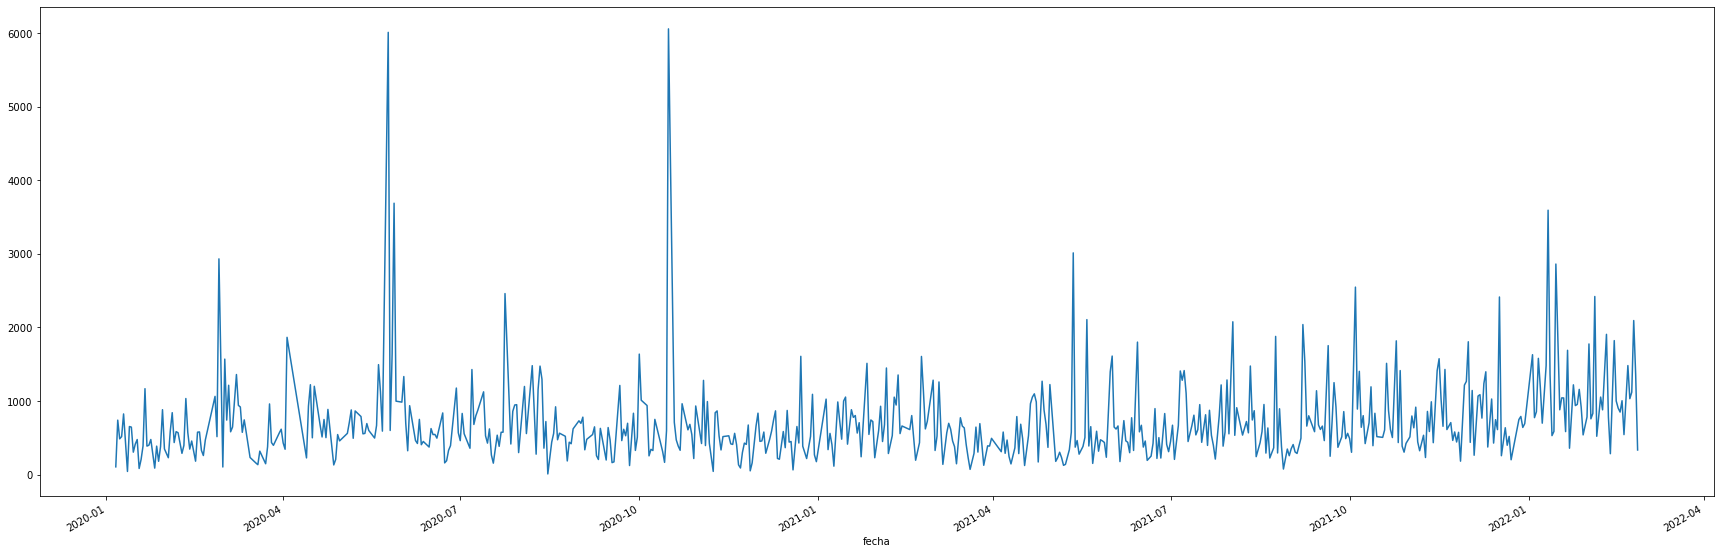

In [53]:
df_ventas_diarias = df_ventas_totales.groupby('fecha').monto_dolar.sum()
df_ventas_diarias.plot(figsize=(30,10))

In [54]:
# Las 25 ventas de mayor monto
df_ventas_totales.groupby('num').monto_dolar.sum().sort_values(ascending=False).head(25)

num
2020-0000004271-fa    5686.278600
2020-0000006335-fa    2977.261000
2020-0000006336-fa    2920.474006
2020-0000004402-fa    2778.282410
2022-0000006399-fa    2280.938776
2021-0000000005-ne    2084.062475
2020-0000000005-ne    2065.660461
2020-0000000108-ne    1866.830040
2021-0000004549-fa    1435.880431
2020-0000004336-fa    1265.419985
2021-0000006281-fa    1219.543568
2020-0000006292-fa    1141.478936
2021-0000006050-fa    1082.725061
2020-0000002238-fa    1016.637129
2020-0000002115-fa    1015.451327
2021-0000005662-ne     983.036638
2022-0000006631-fa     959.163755
2021-0000006247-fa     936.853002
2020-0000004530-fa     923.130116
2021-0000006066-fa     846.770992
2021-0000004877-fa     814.357766
2021-0000006119-fa     811.594203
2021-0000004906-fa     794.944316
2021-0000002433-ne     790.209116
2022-0000006221-ne     787.551020
Name: monto_dolar, dtype: float64

## 8. Carga y limpieza de datos del Inventario<a name="carga-inventario"></a>

Datos sobre el inventario al final del período. Además incluye la clasificación de los productos en líneas de productos.

Con esta información podemos determinar cuáles productos podrían entrar en rotura de stock en función de lo que se ha vendido y lo que queda en stock.

In [55]:
FILE_STOCK = 'datos/in/*inv.xls'

df_stock = read_files(FILE_STOCK, 'fecha', 10)
df_stock.sample(5)

,Código,Descripción,Descrip linea/ validada,SActual,stock real 1,Ajuste(E/S),fecha
2321,04160,CONECTOR CRUZ CABLE COAXIAL PARA TV,ELECTRICIDAD,36.0,NaN,NaN,2022-03-03
3309,05557,PINTURA 1 GALON FONDO GRIS MAQUINA SUPER AYA,PINTURAS,1.0,NaN,NaN,2022-03-03
458,00473,TANIA INTERRUPTOR EMPOTRAR DOBLE 3VIA TRIWAY B...,ELECTRICIDAD,9.0,NaN,NaN,2022-03-03
14,00015,"RIEGO ADAPTADOR HEMBRA 50MM * 1"" AGRO",CONEXIONES PLASTICAS DE RIEGO,47.0,NaN,NaN,2022-03-03
1896,03320,"41WC TUERCA CIEGA INVERTIDA 1/4"" BRONCE NPT ...",TUBERIA DE COBRE Y CONEXIONES DE BRONCE,25.0,NaN,NaN,2022-03-03


In [56]:
cols = ['cod', 'producto', 'linea', 'stock', 'stock2', 'ajuste', 'fecha_stock']
df_stock.columns = cols
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cod          3652 non-null   object 
 1   producto     3652 non-null   object 
 2   linea        3651 non-null   object 
 3   stock        3651 non-null   float64
 4   stock2       0 non-null      float64
 5   ajuste       0 non-null      float64
 6   fecha_stock  3652 non-null   object 
dtypes: float64(3), object(4)
memory usage: 199.8+ KB


In [57]:
# Guardamos solo la información que nos interesa
df_stock = df_stock.loc[:,['cod', 'producto', 'linea', 'stock', 'fecha_stock']]
df_stock.sample(5)

,cod,producto,linea,stock,fecha_stock
2419,04277,"MECHA 5/16"" HSS TAKIMA","MECHAS, BROCAS, SIERRA COPA",3.0,2022-03-03
658,00677,"CONEXION PLASTICA 1"" PLASTICA PARA TANQUE",NO ASIGNADO,14.0,2022-03-03
2874,05110,CONFITERIA BISCOLATA MOOD,NO ASIGNADO,100.0,2022-03-03
1731,02737,"ARANDELA DE PRESION 1/2""",ELEMENTOS DE UNION,44.0,2022-03-03
1082,01133,"GANCHO L TUBOS 1"" *150MM LARGO",ELEMENTOS DE UNION,43.0,2022-03-03


In [58]:
# Eliminamos las filas con NaN (total)
# Transformamos los tipos de columnas para que se guarden con
# el tipo correcto
df_stock.dropna(inplace=True)
df_stock.cod = df_stock.cod.astype(str)
df_stock.fecha_stock = pd.to_datetime(df_stock.fecha_stock)

df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3651 entries, 0 to 3650
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   cod          3651 non-null   object        
 1   producto     3651 non-null   object        
 2   linea        3651 non-null   object        
 3   stock        3651 non-null   float64       
 4   fecha_stock  3651 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 171.1+ KB


## 9. Almacenamiento de los DF<a name="almacenamiento-df"></a>

Los diferentes DF son almacenados en archivos **.parquet** que serán utilizados más tarde en los otros notebooks.

También los guardaremos en archivos **.xlsx** que se utilizarán en la creación de reportes en **Google Data Studio** para failicitar el análisis por parte de los gerentes de la ferretería.

### Ventas Totales

In [59]:
%%time
# Guardamos el DF limpio para su análisis posterior

df_ventas_totales.to_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", 
                    compression='GZIP',
                    engine='pyarrow')

df_ventas_totales.to_csv(f"{BASE_DIR / 'datos/out/ventas.csv'}", sep=';')

# Guardamos el DF en un archivo Excel para utilizar los datos en Google Data Studio
df_ventas_totales.to_excel(f"{BASE_DIR / 'datos/out/ventas.xlsx'}", index = False)

CPU times: user 13.6 s, sys: 188 ms, total: 13.8 s
Wall time: 14.1 s


### Stock

In [60]:
%%time
# Guardamos el DF limpio para su análisis posterior

df_stock.to_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", 
                    compression='GZIP',
                    engine='pyarrow')

df_stock.to_csv(f"{BASE_DIR / 'datos/out/stock.csv'}", sep=';')


# Guardamos el DF en un archivo Excel para utilizar los datos en Google Data Studio
df_stock.to_excel(f"{BASE_DIR / 'datos/out/stock.xlsx'}", index = False)


CPU times: user 743 ms, sys: 27.8 ms, total: 771 ms
Wall time: 780 ms


### Archivo Completo Ventas y Sotock

In [61]:
# Archivo completo ventas y stock
df_ventas_prod_stock = pd.merge(df_ventas_totales, df_stock, on=['cod', 'producto'], how='outer')
df_ventas_prod_stock.sample(30)

,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar,linea,stock,fecha_stock
20242,2021-0000003476-fa,2021-04-12 14:18:00,11.0,0.81,fa,01292,YESQUERO UNIVERSAL,1.0,2021-04-12,2.238957,0.361776,NO ASIGNADO,79.0,2022-03-03
24019,2021-0000003468-ne,2021-10-11 10:05:00,7.0,22.96,ne,00276,"TAPA HEMBRA HG 1/2""",7.0,2021-10-11,3.980000,5.768844,CONEXIONES GALVANIZADAS Y CROMADAS,470.0,2022-03-03
33667,2022-0000008125-ne,2022-02-21 11:06:00,11.0,6.01,ne,00146,"CLAVO ACERO 2.0*3/4"" LISO PAVONADO (BOLSA 100 ...",1.0,2022-02-21,4.620000,1.300866,ELEMENTOS DE UNION,8.0,2022-03-03
34690,2021-0000000034-fa,2021-01-05 11:49:00,14.0,4.09,fa,04304,BTICINO INTERRUPTOR DOBLE EMPOTRAR MARFIL AE22...,1.0,2021-01-05,1.178317,3.471053,ELECTRICIDAD,8.0,2022-03-03
24354,2021-0000006273-fa,2021-11-30 10:49:00,7.0,1216.00,fa,01403,CEMENTO NACIONAL GRIS 42 KGRS,40.0,2021-11-30,4.930000,246.653144,NO ASIGNADO,-2.0,2022-03-03
34257,2021-0000003341-ne,2021-10-06 16:50:00,13.0,48.40,ne,GEN2,GENERICO,2.0,2021-10-06,3.930000,12.315522,NaN,NaN,NaT
25989,2022-0000006443-ne,2022-01-11 16:21:00,13.0,14.91,ne,04404,"NIPLE PLASTICO 1/2"" * 10CTMS/4"" PVC AZUL",5.0,2022-01-11,4.030000,3.699752,"NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",6.0,2022-03-03
41104,2021-0000005037-ne,2021-12-01 16:44:00,13.0,29.18,ne,02901,FUMIGADORA DE 2 LTRS VERT,1.0,2021-12-01,4.820000,6.053942,HERRAMIENTAS MANUALES,0.0,2022-03-03
42401,2021-0000002085-fa,2021-02-25 13:34:00,11.0,1.48,fa,03516,"203P 3/8"" * 3/8"" CONECTOR A MANGUERA ESPIGA*MA...",1.0,2021-02-25,1.845147,0.802104,TUBERIA DE COBRE Y CONEXIONES DE BRONCE,0.0,2022-03-03
26810,2022-0000006418-ne,2022-01-11 11:23:00,14.0,6.24,ne,04378,"NIPLE PLASTICO 3/4"" * 5 CTMS/2"" O 4 CTM 1 1/2""",3.0,2022-01-11,4.030000,1.548387,"NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",29.0,2022-03-03


In [63]:
%%time
# Guardamos el DF limpio para su análisis posterior

df_ventas_prod_stock.to_parquet(f"{BASE_DIR / 'datos/out/ventas_stock.parquet'}", 
                    compression='GZIP',
                    engine='pyarrow')

df_ventas_prod_stock.to_csv(f"{BASE_DIR / 'datos/out/ventas_stock.csv'}", sep=';', index = False)


# Guardamos el DF en un archivo Excel para utilizar los datos en Google Data Studio
df_ventas_prod_stock.to_excel(f"{BASE_DIR / 'datos/out/ventas_stock.xlsx'}", index = False)


CPU times: user 16.6 s, sys: 214 ms, total: 16.8 s
Wall time: 17.1 s
